In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from scipy.integrate import trapezoid as sp_trapezoid

SAVE_PLOTS=False
STANDARD_DPI=300
FIGSIZE=(5,3)

In [10]:
def load_noise_data():
    noise_levels_filepath = "data/dark_pmt/pmt1/I_V_noise_700_2285V.csv"
    return pd.read_csv(noise_levels_filepath)
noise_data = load_noise_data()
noise_data.head(2)

,time,pmt_high_voltage,pmt_current,v_p2p_ch1,v_rms_ch1,v_p2p_ch2,v_rms_ch2
0,1.741440e+09,700.1,67.780,0.0400,0.010568,0.0408,0.012731
1,1.741440e+09,705.1,68.495,0.0424,0.011586,0.0424,0.011411


In [11]:
# find the row inm the data that corresponds to a voltage of 1450V (rounded to the nearest whole number)
noiseat1450_row = noise_data.loc[noise_data['pmt_high_voltage'].round() == 1450]
noiseat1450_row

,time,pmt_high_voltage,pmt_current,v_p2p_ch1,v_rms_ch1,v_p2p_ch2,v_rms_ch2
150,1.741441e+09,1449.9,181.795,0.044,0.009966,0.044,0.010358


In [12]:

def load_h5_data(filename):
    data = {}
    with h5py.File(filename, 'r') as f:
        for att in f.keys():
            data[int(att)] = {'CH1': [], 'CH2': []}

            for i in f[att]['CH1']:
                arr = np.array(f[att]['CH1'][i])  # Load as NumPy array
                df = pd.DataFrame(arr, columns=['t', 'V'])  # Convert to DataFrame
                data[int(att)]['CH1'].append(df)

            for i in f[att]['CH2']:
                arr = np.array(f[att]['CH2'][i])
                df= pd.DataFrame(arr, columns=['t', 'V'])
                data[int(att)]['CH2'].append(df)

    return data

In [13]:
signals_filepath = 'data/pmt_light_attenuation/signals_20250309-104658.h5'
signals = load_h5_data(signals_filepath)
keys = sorted(signals.keys())
keys

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

In [14]:
def get_avg_p2p(key, channel):
    sigs = signals[key][channel]
    peak_to_peak = np.array([df['V'].max() - df['V'].min() for df in sigs])
    return peak_to_peak.mean()

def get_avg_integral(key, channel, threshold):
    df = signals[key][channel][0]
    # integrate each signal with respect to time
    threshold = np.std(df['V']) * 1  # Example: Half of the standard deviation
    #select only the range where the signal is above the threshold
    df = df[df['V'].abs() > threshold]
    integral = sp_trapezoid(df['V'], df['t'])
    return np.abs(integral) 

In [15]:
df = pd.DataFrame({'attenuation': keys, 'CH1': [get_avg_p2p(k, 'CH1') for k in keys], 'CH2': [get_avg_p2p(k, 'CH2') for k in keys]})
df.head(2)

,attenuation,CH1,CH2
0,0,9.48,8.624
1,1,8.76,7.712


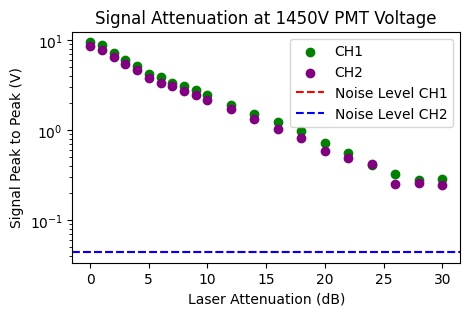

In [16]:
plt.figure(figsize=FIGSIZE)
plt.scatter(df['attenuation'], df['CH1'], color='green', label='CH1')
plt.scatter(df['attenuation'], df['CH2'], color = 'purple', label='CH2')

# Add horizontal lines for noise levels
plt.axhline(y=noiseat1450_row['v_p2p_ch1'].values[0], color='r', linestyle='--', label='Noise Level CH1')
plt.axhline(y=noiseat1450_row['v_p2p_ch2'].values[0], color='b', linestyle='--', label='Noise Level CH2')

plt.xlabel('Laser Attenuation (dB)')
plt.ylabel('Signal Peak to Peak (V)')

# set log y
plt.yscale('log')

plt.title('Signal Attenuation at 1450V PMT Voltage')
plt.legend()
# plt.grid(True)

if SAVE_PLOTS:
    savefig_dir = 'plots/pmt_light_attenuation_tests/pmt1/'
    plt.savefig(savefig_dir + 'att_sig_1450V.jpg', dpi=STANDARD_DPI)

plt.show()

## Fitting a light response coefficient

We discard the last 2 points as the noise to signal ratio is too high.

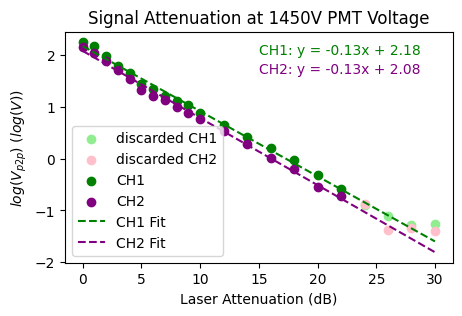

In [22]:
# calculate log of ch1 and ch2
df['logCH1'] = np.log(df['CH1'])
df['logCH2'] = np.log(df['CH2'])

# make a copy of the dataframe and discard the last two points to avoid the noise level

df_fit = df[:-4].copy()

plt.figure(figsize=FIGSIZE)

plt.scatter(df['attenuation'][-4:], df['logCH1'][-4:], color='lightgreen', label='discarded CH1')
plt.scatter(df['attenuation'][-4:], df['logCH2'][-4:], color = 'pink', label='discarded CH2')

plt.scatter(df_fit['attenuation'], df_fit['logCH1'], color='green', label='CH1')
plt.scatter(df_fit['attenuation'], df_fit['logCH2'], color = 'purple', label='CH2')

# fit lines to the ch1 and ch2 log data
m1, b1 = np.polyfit(df_fit['attenuation'], df_fit['logCH1'], 1)
m2, b2 = np.polyfit(df_fit['attenuation'], df_fit['logCH2'], 1)

# display the fit line parameters as text on the plot
plt.text(0.5, 0.9, f'CH1: y = {m1:.2f}x + {b1:.2f}', color='green', transform=plt.gca().transAxes)
plt.text(0.5, 0.82, f'CH2: y = {m2:.2f}x + {b2:.2f}', color='purple', transform=plt.gca().transAxes)

plt.plot(df['attenuation'], m1*df['attenuation'] + b1, color='green', label='CH1 Fit', linestyle='--')
plt.plot(df['attenuation'], m2*df['attenuation'] + b2, color='purple', label='CH2 Fit', linestyle='--')

plt.xlabel('Laser Attenuation (dB)')
plt.ylabel(r'$log(V_{p2p})$ $(log(V))$')
plt.title('Signal Attenuation at 1450V PMT Voltage')
plt.legend()

if SAVE_PLOTS:
    savefig_dir = 'plots/pmt_light_attenuation_tests/pmt1/'
    plt.savefig(savefig_dir + 'att_sig_log_1450V_fit.jpg', dpi=STANDARD_DPI)
plt.show()


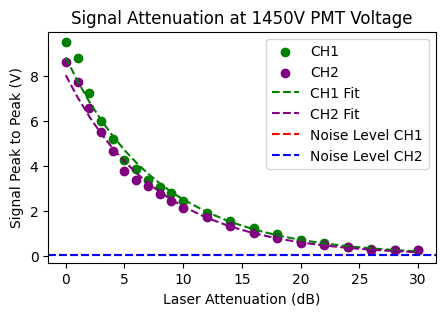

In [18]:
# transform the line parameters back to the non-logarithmic volt scale. Display the transformed line parameters as text on the plot

fig, ax = plt.subplots(figsize=FIGSIZE)
plt.scatter(df['attenuation'], df['CH1'], color='green', label='CH1')
plt.scatter(df['attenuation'], df['CH2'], color = 'purple', label='CH2')

plt.plot(df['attenuation'], np.exp(m1*df['attenuation'] + b1), color='green', label='CH1 Fit', linestyle='--')
plt.plot(df['attenuation'], np.exp(m2*df['attenuation'] + b2), color='purple', label='CH2 Fit', linestyle='--')

plt.axhline(y=noiseat1450_row['v_p2p_ch1'].values[0], color='r', linestyle='--', label='Noise Level CH1')
plt.axhline(y=noiseat1450_row['v_p2p_ch2'].values[0], color='b', linestyle='--', label='Noise Level CH2')

plt.xlabel('Laser Attenuation (dB)')
plt.ylabel('Signal Peak to Peak (V)')
plt.title('Signal Attenuation at 1450V PMT Voltage')
plt.legend()

if SAVE_PLOTS:
    savefig_dir = 'plots/pmt_light_attenuation_tests/pmt1/'
    plt.savefig(savefig_dir + 'att_sig_exp_1450V_fit.jpg', dpi=STANDARD_DPI)
plt.show()
